In [1]:
import sys

In [ ]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

In [57]:
import gzip
import json
import json_tricks
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim

from rearrangement.task.sensors import *

from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image

from habitat_sim.physics import MotionType


In [ ]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [ ]:
with open('data/replays/replays_2AMycSE5GM2424pveZ4xDL_300_Scandinavia.glb.json', 'r') as f:
    data = json_tricks.load(f)

In [ ]:
eid = data['episode_id']
scene_id = data['scene_id']

In [23]:
eid

'300'

In [ ]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [ ]:
config.defrost()
config.DATASET.CONTENT_SCENES = ['rearrangement_v1_train_n=1000_o=5_{}'.format(scene_id.split('/')[-1].split('.')[0])]
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.freeze()

In [ ]:
config.DATASET

In [ ]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [25]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)

2020-10-25 00:56:23,696 Initializing dataset RearrangementDataset-v0
2020-10-25 00:56:23,760 initializing sim RearrangementSim-v0
2020-10-25 00:56:29,645 Initializing task RearrangementTask-v0


In [27]:
for ep in env.episodes:
    if ep.episode_id == eid:
        break

In [28]:
ep.episode_id

'300'

In [29]:
env._current_episode = ep

In [106]:
env._reset_stats()

if env._current_episode is not None:
    env._current_episode._shortest_path_cache = None
env.reconfigure(env._config)
obs = env.task.reset(episode=env.current_episode)
env._task.measurements.reset_measures(
    episode=env.current_episode, task=env.task
)
metrics = env.get_metrics()

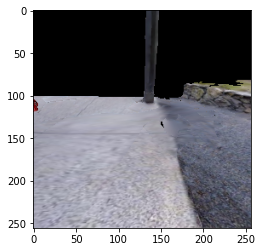

In [107]:
plt.imshow(obs['rgb'])

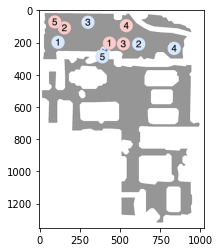

In [82]:
top_down_map = maps.get_topdown_map(
    env._task._simple_pathfinder,
    env._sim.get_agent(0).state.position[1],
    1024
)

top_down_map = maps.colorize_topdown_map(top_down_map)
agent_position = env._sim.get_agent_state().position
a_x, a_y = maps.to_grid(
    agent_position[2],
    agent_position[0],
    top_down_map.shape[0:2],
    sim=env._sim,
)

episode = env.current_episode
object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]

grid_object_positions = []
grid_goal_positions = []

for i, obj_pos in enumerate(object_positions):
    tdm_pos = maps.to_grid(
        obj_pos[2],
        obj_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )
    grid_object_positions.append(tdm_pos)

# draw the objectgoal positions.
for i, goal_pos in enumerate(goal_positions):
    tdm_pos = maps.to_grid(
        goal_pos[2],
        goal_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    grid_goal_positions.append(tdm_pos)
    
grid_current_positions = [None] * len(object_positions)
for sim_obj_id in env._sim.get_existing_object_ids():
    if sim_obj_id != env._task.agent_object_id:
        obj_id = env._task.sim_object_to_objid_mapping[sim_obj_id]
        position = env._sim.get_translation(sim_obj_id)
        curr_pos = maps.to_grid(position[2], position[0], top_down_map.shape[0:2], sim=env._sim)
        grid_current_positions[obj_id] = curr_pos

    
top_down_map = maps.draw_agent(
    image=top_down_map,
    agent_center_coord=[a_x, a_y],
    agent_rotation=0,
    agent_radius_px=min(top_down_map.shape[0:2]) / 32,
)

top_down_map = maps.draw_object_info(top_down_map, grid_goal_positions, suffix='g')
top_down_map = maps.draw_object_info(top_down_map, grid_current_positions, suffix='c')

plt.imshow(top_down_map)

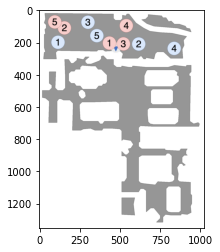

In [61]:
plt.imshow(top_down_map)

In [99]:
def restore_state(replay, env):
    for sim_obj_id, obj_id in replay['sim_object_id_to_objid_mapping'].items(): 
        curr_sim_obj_id = env._task.sim_object_to_objid_mapping[obj_id]
        env._sim.set_object_motion_type(
            MotionType.KINEMATIC, curr_sim_obj_id
        )
        env._sim.set_translation(replay['current_position'][sim_obj_id], curr_sim_obj_id)
        env._sim.set_object_motion_type(
            MotionType.STATIC, curr_sim_obj_id
        )
        agent_cfg = env._sim._get_agent_config(0)
        env._sim.set_agent_state(
            replay['agent_pos'],
            agent_cfg.START_ROTATION,
            0,
        )
        env._sim.set_translation(replay['agent_pos'], env._task.agent_object_id)
        
        
        print(sim_obj_id, obj_id, curr_sim_obj_id)
    env._task.measurements.update_measures(
        episode=env.current_episode, action=0, task=env.task
    )

In [100]:
restore_state(data, env)

4 0 4
3 1 3
2 2 2
1 3 1
0 4 0
Object To Goal distance 4 [-5.018838405609131, -0.122658804, -1.6616384983062744] [-8.737895965576172, -0.05257029831409454, -4.37989616394043] [-4.8209167 -0.1226588 -2.1133544] 2
Saving Replay:  data/replays/replays_4nt8Vyqw2b4kd4Veu7wM4e_300_Scandinavia.glb.json
Agent To Object distance 4 [-5.018838405609131, -0.122658804, -1.6616384983062744] [-4.8209167 -0.1226588 -2.1133544] data/scene_datasets/gibson_train_val/Scandinavia.glb 300 2
Saving Replay:  data/replays/replays_cbuXCJJTEfRVbH696CgBv2_300_Scandinavia.glb.json


/srv/flash1/hagrawal9/envs/habitat/lib/python3.6/site-packages/json_tricks/encoders.py:367: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


In [102]:
for obj_id, goal in enumerate(env.current_episode.goals):

    agent_state = env._sim.get_agent_state()
    agent_position = agent_state.position
    sim_obj_id = env._task.sim_object_to_objid_mapping[obj_id]
    previous_position = np.array(
        env._sim.get_translation(sim_obj_id)
    ).tolist()

    goal_position = env.current_episode.goals[obj_id].position
    previous_position[1] = agent_position[1]
 
    d = geodesic_distance(
        env._sim.pathfinder, previous_position, agent_position
    )
    print(obj_id, d)

0 3.8225903511047363
1 2.8618922233581543
2 3.2451040744781494
3 5.400570869445801
4 inf


In [96]:
env.get_metrics()

{'object_to_goal_distance': {4: 3.453911066055298,
  3: 4.130092620849609,
  2: 3.2350261211395264,
  1: 5.9219536781311035,
  0: 4.004764556884766},
 'agent_to_object_distance': {4: 1.745629906654358,
  3: 4.5438690185546875,
  2: 2.9267420768737793,
  1: 1.7977344989776611,
  0: 4.523466110229492},
 'top_down_map': None}

In [ ]:
for action in data['actions']:
    obs = env.step(action['action'])
    metrics = env.get_metrics()
    metrics['ag']
    plt.imshow(obs['rgb'])
    plt.title(action)
    plt.show()